In [15]:
import glob

import numpy as np
import pandas
from pandas.core.window.indexers import BaseIndexer

In [16]:

class CustomIndexer(BaseIndexer):
    def get_window_bounds(self, num_values=0, min_periods=None, center=None, closed=None):
        end = np.arange(0, num_values, dtype="int64")
        end += 4
        start = end - 3

        end = np.clip(end, 0, num_values)
        start = np.clip(start, 0, num_values)

        return start, end


def concat_rows(df, n):
    new_cols = [
        f"{col}{idx}"
        for idx in range(1, n + 1)
        for col in df.columns
    ]
    n_cols = len(df.columns)
    new_df = pandas.DataFrame(
        df.values.reshape([-1, n_cols * n]),
        columns=new_cols
    )
    return new_df

In [ ]:
#filename = "data/2021_LoL_esports_match_data_from_OraclesElixir_20210515.csv"


path = r'C:\Users\duncan\PycharmProjects\leaguepredict\data'  # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pandas.read_csv(filename, index_col=None, header=0)
    li.append(df)

data = pandas.concat(li, axis=0, ignore_index=True)

#data = pandas.read_csv(filename)

In [18]:
team_columns = ["date", "actual_result", "playerid", "gameid", "team", "gamelength", "result", "dragons", "barons",
                "riftheralds", "towers"]
player_columns = ["date", "player", "gameid", "kills", "deaths", "assists", "dpm", "damageshare",
                  "damagetakenperminute", "wpm",
                  "vspm", "earned gpm", "cspm", "csat10", "goldat10", "killsat10", "deathsat10", "assistsat10",
                  "csat15", "goldat15", "killsat15", "deathsat15", "assistsat15"]


In [19]:
data = data.sort_values(by=["date", "playerid"], ascending=[0, 1])
data = data.reset_index(drop=True)
data["actual_result"] = data["result"]

In [20]:


indexer = CustomIndexer(window_size=1)

player_data = (
    data
        .filter(player_columns)
        .groupby(pandas.Grouper(key="player"))
        .rolling(window=indexer, min_periods=1, on="gameid")
        .mean()
        .reset_index()
        .rename(columns={"level_1": "id"})
        .sort_values(by="id")
        .reset_index()
        .drop(columns=["index", "player", "id", "gameid"])
)



In [21]:
team_data = (
    data
        .query("playerid > 10")
        .filter(team_columns)
        .groupby(pandas.Grouper(key="team"))
        .rolling(window=indexer, min_periods=1, on="actual_result")
        .mean()
        .reset_index()
        .rename(columns={"level_1": "id"})
        .sort_values(by="id")
        .reset_index()
        .drop(columns=["index", "playerid", "id"])
)

In [22]:
game_data_player = concat_rows(player_data, 10)
game_data_team = concat_rows(team_data, 2)
game_data_team.drop(columns=["actual_result2", "team1", "team2"], inplace=True)

game_data = (
    pandas
        .concat([game_data_team, game_data_player], axis=1)
        .dropna()
)

game_result = game_data["actual_result1"]
game_data.drop(columns=["actual_result1"], inplace=True)


In [99]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier, Ridge

from sklearn import preprocessing
from sklearn import utils

print(game_result)
lab_enc = preprocessing.LabelEncoder()
encoded = lab_enc.fit_transform(game_result)

trainX, testX, trainY, testY = train_test_split(
    game_data, encoded, test_size=.33)
model = RidgeClassifier()
model.fit(trainX, trainY)

print(model.score(trainX, trainY))
print(model.score(testX, testY))
print()

# np.savetxt("aggr_data.csv", data_aggr)


0        1
1        0
2        0
3        1
4        0
        ..
44206    0
44207    1
44208    1
44209    1
44210    0
Name: actual_result1, Length: 35645, dtype: object
0.6576082405158697
0.65323471903426



In [91]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model

from sklearn import preprocessing
from sklearn import utils

print(game_result.mean())
lab_enc = preprocessing.LabelEncoder()
encoded = lab_enc.fit_transform(game_result)
print(encoded)
trainX, testX, trainY, testY = train_test_split(
    game_data, encoded, test_size=.33)
model = linear_model.LogisticRegression(fit_intercept=False, multi_class="ovr")
model.fit(trainX, trainY)

print(model.score(trainX, trainY))
print(model.score(testX, testY))


# np.savetxt("aggr_data.csv", data_aggr)

0.5266657315191472
[1 0 0 ... 1 1 0]


c:\users\duncan\pycharmprojects\leaguepredict\venv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.6049744577506071
0.5976366573153107


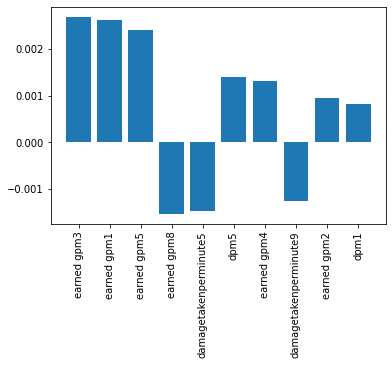

In [25]:
import matplotlib.pyplot as plt

iterable = sorted(zip(abs(model.coef_[0]), model.coef_[0], trainX.columns.values), key=lambda x: x[0])
sdata = np.array([a for a in reversed(iterable)])

x = sdata[:, 2]
y = sdata[:, 1].astype(float)

plt.bar(x[:10], y[:10])
plt.xticks(rotation=90)
plt.show()

In [26]:
import os
import torch
import torch.nn as nn

from torch.utils.data import TensorDataset, DataLoader


def create_dataset(input_data):
    #random.shuffle(input_data)

    target = torch.tensor(game_result, dtype=torch.long)
    #print(input_data[0,:])
    input_data = torch.tensor(input_data.values.astype(np.float32))
    # input_data = torch.tensor(input_data, dtype=torch.float32)
    #target = torch.tensor(input_data, dtype=torch.long)

    dataset = TensorDataset(input_data, target)

    # Compute batch sizes
    size = len(input_data)
    p1 = int(size * .8)
    p2 = int(size * .1)
    p3 = size - p1 - p2

    train, validation, test = torch.utils.data.random_split(dataset, (p1, p2, p3))

    tra_loader = DataLoader(train, batch_size=64, shuffle=True)
    val_loader = DataLoader(validation, batch_size=128)
    tes_loader = DataLoader(test, batch_size=128)

    return tra_loader, val_loader, tes_loader

In [27]:
import os
import torch
import torch.nn as nn

from torch.utils.data import TensorDataset, DataLoader


class TestNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()

        self.seq = nn.Sequential(nn.Linear(input_size, 128),
                                 # nn.BatchNorm1d(64),
                                 # nn.ReLU(),
                                 # nn.Dropout(0.5),
                                 nn.Linear(128, 64),
                                 # nn.BatchNorm1d(32),
                                 # nn.ReLU(),
                                 # nn.Dropout(0.5),
                                 nn.Linear(64, 32),
                                 nn.Linear(32, 16),
                                 # nn.BatchNorm1d(16),
                                 # nn.ReLU(),
                                 nn.Linear(16, output_size))

        def weight_init(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

        self.seq.apply(weight_init)

    def forward(self, x):
        out = self.seq(x)
        return out


def training(train: DataLoader, validation: DataLoader):
    epochs = 150

    model = TestNetwork(game_data.shape[1], 2).float()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # model.train()
    for e in range(epochs):
        val_loss = []
        val_acc = []
        model.train()
        for i, (inputs, target) in enumerate(train):
            inputs, target = inputs.to("cpu"), target.to("cpu")
            optimizer.zero_grad()
            pred_target = model(inputs)
            #pred_target = (pred_target > 0.5).float()
            loss = criterion(pred_target, target.flatten())
            loss.backward()

            val_loss.append(loss.item())

            pred_target = pred_target.detach()
            _, pred_target = torch.max(pred_target, dim=1)
            correct = (pred_target == target.flatten()).sum().item()
            acc = correct / len(target)
            val_acc.append(acc)

            optimizer.step()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)

        # print("TRAIN LOSS", np.mean(val_loss))
        # print("TRAIN ACC", np.mean(val_acc))

        val_loss = []
        val_acc = []
        with torch.no_grad():
            model.eval()
            for i, (input, target) in enumerate(validation):
                input, target = input.to("cpu"), target.to("cpu")
                pred_target = model(input)

                loss = criterion(pred_target, target.flatten().long())

                #pred_target = pred_target[pred_target > 0.5]

                _, pred_target = torch.max(pred_target, dim=1)
                correct = (pred_target == target.flatten()).sum().item()
                acc = correct / len(target)

                val_loss.append(loss.item())
                val_acc.append(acc)
        print('val acc', np.mean(val_acc))

    return model


def testing(model, test: DataLoader):
    acc_list = []
    model.eval()
    with torch.no_grad():
        for i, (input, target) in enumerate(test):
            input, target = input.to("cpu"), target.to("cpu")
            pred_target = model(input)

            _, pred_target = torch.max(pred_target, dim=1)
            correct = (pred_target == target.flatten()).sum().item()
            acc = correct / len(target)
            acc_list.append(acc)
    print('test acc', np.mean(acc_list))


In [28]:
train, validate, test = create_dataset(game_data)
model = training(train, validate)
testing(model, test)

val acc 0.5073371362433863
val acc 0.48407531415343913
val acc 0.5189525462962963
val acc 0.5339161706349207
val acc 0.4783916170634921
val acc 0.4949570105820106
val acc 0.5438264715608466
val acc 0.5694961144179894
val acc 0.5577153604497355
val acc 0.49447131283068785
val acc 0.5500992063492064
val acc 0.5500475363756614
val acc 0.5243572255291006
val acc 0.5346602182539683
val acc 0.531229332010582
val acc 0.5238405257936508
val acc 0.5225487764550264
val acc 0.5328000992063492
val acc 0.5291211970899471
val acc 0.49654844576719576
val acc 0.5545118220899471
val acc 0.503957919973545
val acc 0.537140376984127
val acc 0.5036065641534392
val acc 0.5056320271164021
val acc 0.5147672784391534
val acc 0.5012194113756614
val acc 0.5520316633597884
val acc 0.5600198412698413
val acc 0.5356109457671957
val acc 0.5457589285714286
val acc 0.5050533234126984
val acc 0.5786416997354497
val acc 0.6022032076719576
val acc 0.5669126157407407
val acc 0.5103546626984127
val acc 0.5206783234126984
v

In [131]:
def get_team(team_name):
    teams = data.team.unique().astype(str).flatten()
    if team_name in teams:
        return team_name
    matches = np.char.find(teams, team_name)
    selection = teams[matches >= 0]
    if len(selection) == 0:
        print("No teams found with that name.")
        return None
    if len(selection) > 1:
        print("Multiple teams found: %s" % ", ".join(selection))
        return None
    return selection[0]


def get_something(all_data, blue_team="Fnatic", red_team="Rogue"):
    blue_team = get_team(blue_team)
    red_team = get_team(red_team)
    if blue_team is None or red_team is None:
        return

    aggregation = None
    for team in [blue_team, red_team]:
        players = all_data.query(f"team=='{team}'").filter(["player"]).head(5)

        for player in players.player.values:
            new_player_data = (
                all_data
                    .filter(player_columns)
                    .query(f"player == '{player}'")
                    .head(3)
                    .mean(axis=0)
                    .to_frame()
                    .transpose()
            )

            if aggregation is None:
                aggregation = new_player_data
            else:
                aggregation = aggregation.append(new_player_data, ignore_index=True)

    aggregation = aggregation.reindex(sorted(aggregation.columns), axis=1)
    aggregation = concat_rows(aggregation, 10)
    blue_team_data = (
        all_data
            .query("playerid > 10")
            .query(f"team=='{blue_team}'")
            .filter(team_columns)
            .head(3)
            .rolling(3, on="actual_result")
            .mean()
            .tail(1)
    )
    red_team_data = (
        all_data
            .query("playerid > 10")
            .query(f"team=='{red_team}'")
            .filter(team_columns)
            .head(3)
            .rolling(3, on="actual_result")
            .mean()
            .tail(1)
    )
    new_team_data = blue_team_data.append(red_team_data, ignore_index=True)
    new_team_data = concat_rows(new_team_data, 2)

    new_team_data.drop(columns=["actual_result2", "playerid1", "playerid2"], inplace=True)

    new_game_data = (
        pandas
            .concat([new_team_data, aggregation], axis=1)
            .dropna()
    )

    new_game_data.drop(columns=["actual_result1"], inplace=True)

    return new_game_data

matchups = [
    ("Schalke 04 Esports", "Excel Esports"),
    ("Team Vitality", "Misfits Gaming"),
    ("MAD Lions", "Astralis"),
    ("G2 Esports", "SK Gaming"),
    ("Fnatic", "Rogue"),
    ("Astralis", "Schalke 04 Esports"),
    ("Excel Esports", "Team Vitality"),
    ("Rogue", "MAD Lions"),
    ("Fnatic", "SK Gaming"),
    ("Misfits Gaming", "G2 Esports"),
]

for blue_team, red_team in matchups:

    X = get_something(data, blue_team, red_team)
    if X is not None:
        print(model.predict(X))
        prob = (model.decision_function(X)[0] + 1) / 2
        odds = (1 / prob, 1 / (1 - prob))
        print(prob, odds)



[1]
0.5494207857179919 (1.8200985947285995, 2.219365581684647)
[0]
0.30740103867234964 (3.2530794440999684, 1.4438369905768977)
[1]
0.6706877839195964 (1.4910067306666233, 3.0366319594893008)
[1]
0.5264833779928211 (1.8993951980258637, 2.1118582823156715)
[1]
0.5804041481216335 (1.722937376027218, 2.3832456768182793)
[0]
0.4370175944372089 (2.288237390734347, 1.776254444400158)
[0]
0.36907766100854666 (2.7094568586659684, 1.5849811271519207)
[0]
0.4980514811903187 (2.007824567874086, 1.9922361806573232)
[1]
0.6459249028240943 (1.5481675898046796, 2.8242596216903575)
[1]
0.6134419733362927 (1.6301460341250464, 2.5869337357466566)
